# <center>PROYECTO INVESTIGACIÓN - EJERCICIO 1<center>

<left>Brais Fojo Couce - brais.fojo@udc.es<left>  
<left>Rodrigo Romay Aba - rodrigo.romay@udc.es<left>

## Librerías necesarias

In [1]:
import os
import random
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from skimage.io import imread
from sklearn.svm import SVC
from skimage.transform import resize
from skimage.color import rgb2hsv, rgb2gray, rgb2lab
from skimage.filters import sobel, gaussian, rank
from skimage.feature import canny
from skimage.morphology import disk
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from skimage.morphology import opening, closing, dilation, erosion, disk
from sklearn.metrics import classification_report, jaccard_score, f1_score, accuracy_score, recall_score

## Preprocesado
### El primer paso es preprocesar los datos para dejarlos en un formato adecuado para el análisis posterior. Esto incluye:
- Definir una semilla (888) para asegurar la reproducibilidad de los resultados.
- Cargar las imágenes y las máscaras, para posteriormente reescalarlas a un tamaño adecuado (target_size).
- Definimos la función extract_features, que extrae las características que utilizaremos para entrenar el modelo. En este caso usamos: RGB, HSV, CIE Lab, Canny y Sobel (para los bordes), entropía y blur.
- Es crucial también el balanceo de clases, ya que en este caso las imágenes tienen muchos más píxeles de fondo que de carretera. Para ello, cogemos el mismo num de píxeles de cada clase para evitar el desbalanceo.
- Finalmente, dividimos las imágenes en conjuntos de entrenamiento (16 imágenes), validación (2 imágenes) y test (2 imágenes) y emparejamos las respectivas entradas con sus salidas (máscaras).

In [2]:
SEED = 888 # reproducibilidad

target_size = (1000, 1000) # tamaño reescalado

def load_images_sorted(path):
    return sorted([os.path.join(path, f) for f in os.listdir(path) if f.endswith(('.tiff', '.tif'))])

def get_data(path):
    sat_path = os.path.join(path, "sat")
    gt_path = os.path.join(path, "gt")
    
    sat_files = load_images_sorted(sat_path)
    gt_files = load_images_sorted(gt_path)
    
    # Cargamos y hacemos reescalado
    X_raw = np.array([resize(imread(f), target_size, mode='reflect', anti_aliasing=True) for f in sat_files])
    # Para la máscara usamos order=0
    y_raw = np.array([resize(imread(f), target_size, order=0, mode='reflect', preserve_range=True).astype(bool) for f in gt_files])
    
    return X_raw, y_raw

def extract_features(images):  # extracción características
    features_list = []
    
    for i, img in enumerate(images):
        # Espacios de color
        img_gray = rgb2gray(img)
        img_hsv = rgb2hsv(img)
        img_lab = rgb2lab(img)
        
        # Textura y Bordes (Canny y Sobel)
        edge_canny = canny(img_gray, sigma=1) 
        edge_sobel = sobel(img_gray)
        
        # Caracterísitcas de contexto (Entropía)
        img_gray_u8 = (img_gray * 255).astype(np.uint8)
        texture_entropy = rank.entropy(img_gray_u8, disk(3)) 
        
        # Blur: Información de baja frecuencia
        blur_gaussian = gaussian(img_gray, sigma=2)

        h, w = img.shape[:2]
        
        # Matriz de características
        img_feats = np.stack([
            img[:,:,0].flatten(),   # R
            img[:,:,1].flatten(),   # G
            img[:,:,2].flatten(),   # B
            img_hsv[:,:,0].flatten(), # Hue
            img_hsv[:,:,1].flatten(), # Saturation
            img_lab[:,:,0].flatten(), # L (Lightness)
            edge_sobel.flatten(),     # Bordes Sobel
            edge_canny.flatten(),     # Bordes Canny
            texture_entropy.flatten(), # Entropía
            blur_gaussian.flatten()    # Contexto suavizado
        ], axis=1)
        
        features_list.append(img_feats)
        
        print(f"Procesada imagen {i+1}/{len(images)}")

    return np.vstack(features_list)

# BALANCEO DE DATOS (DownSampling)
def balance_data(X, y):
    # Indices de cada clase
    idx_no_road = np.where(y == 0)[0]
    idx_road = np.where(y == 1)[0]
    
    # Coger mismo número de cada clase (evitar predominancia de una clase)
    n_samples = len(idx_road)

    idx_no_road_down = resample(idx_no_road, 
                                replace=False, 
                                n_samples=int(n_samples * 1.5), # Cogemos un poco más de fondo (ratio 1:1.5)
                                random_state=SEED)
    
    # Juntamos indices
    idx_final = np.concatenate([idx_no_road_down, idx_road])
    np.random.shuffle(idx_final) # Mezclar para que no estén ordenados
    
    return X[idx_final], y[idx_final]


# EJECUCIÓN

# Cargar imágenes
data_path = "DataSet_1/roads" 

all_images, all_masks = get_data(data_path)
total_imgs = len(all_images)
print(f"Total imágenes disponibles: {total_imgs}")

# Separar conjuntos
indices = list(range(total_imgs))
random.seed(SEED) 
random.shuffle(indices)

# Test: 2 imágenes
idx_test = indices[:2]
# Val: 2 imágenes
idx_val = indices[2:4]
# Train: 16 imágenes
idx_train = indices[4:]

# Función auxiliar para emparejar mismas entradas con salidas
def filter_by_idx(data_list, indices):
    return [data_list[i] for i in indices]

X_train_raw = filter_by_idx(all_images, idx_train)
y_train_raw = filter_by_idx(all_masks, idx_train)

X_val_raw   = filter_by_idx(all_images, idx_val)
y_val_raw   = filter_by_idx(all_masks, idx_val)

X_test_raw  = filter_by_idx(all_images, idx_test)
y_test_raw  = filter_by_idx(all_masks, idx_test)

# Procesar y balancear entrenamiento
print("\nProcesando TRAIN")
X_train_feats = extract_features(X_train_raw)
y_train_labels = np.array(y_train_raw).flatten()

X_train, y_train = balance_data(X_train_feats, y_train_labels)

# Procesar validación y test (sin balancear)
print("\nProcesando VALIDACIÓN")
X_val = extract_features(X_val_raw)
y_val = np.array(y_val_raw).flatten()

print("\nProcesando TEST")
X_test = extract_features(X_test_raw)
y_test = np.array(y_test_raw).flatten()


# RESUMEN FINAL
print("\nResumen")
print(f"TRAIN: {X_train.shape} muestras/características")
print(f"VAL: {X_val.shape} muestras/características")
print(f"TEST: {X_test.shape} muestras/características")

Total imágenes disponibles: 20

Procesando TRAIN
Procesada imagen 1/16
Procesada imagen 2/16
Procesada imagen 3/16
Procesada imagen 4/16
Procesada imagen 5/16
Procesada imagen 6/16
Procesada imagen 7/16
Procesada imagen 8/16
Procesada imagen 9/16
Procesada imagen 10/16
Procesada imagen 11/16
Procesada imagen 12/16
Procesada imagen 13/16
Procesada imagen 14/16
Procesada imagen 15/16
Procesada imagen 16/16

Procesando VALIDACIÓN
Procesada imagen 1/2
Procesada imagen 2/2

Procesando TEST
Procesada imagen 1/2
Procesada imagen 2/2

Resumen
TRAIN: (1515140, 10) muestras/características
VAL: (2000000, 10) muestras/características
TEST: (2000000, 10) muestras/características


## Comparativa de clasificadores (XGBoost, Decision Tree, SVM, KNN)
### Una vez tenemos los datos preprocesados, entrenamos y evaluamos varios clasificadores para ver cuál se adapta mejor a nuestro problema. En concreto, probamos con XGBoost, Decision Tree, SVM y KNN. Para cada clasificador, realizamos los siguientes pasos:
- Primero definimos unas operaciones de post-procesado para mejorar los resultados de las predicciones. Probamos Opening, Closing, Dilation y Erosion.
- Creamos una función de visualización y calculo de resultados para comparar las métricas crudas y las mejoradas tras el post-procesado. Las métricas que incluimos son: Accuracy, Recall, Jaccard (IoU: Intersection over Union) y Dice.
- Finalmente llamamos a esta función para cada clasificador y mostramos los resultados obtenidos, observando así el rendimiento de cada uno con todas las características extraídas.


############################################################
PROCESANDO MODELO: XGBoost
############################################################
Procesada imagen 1/1


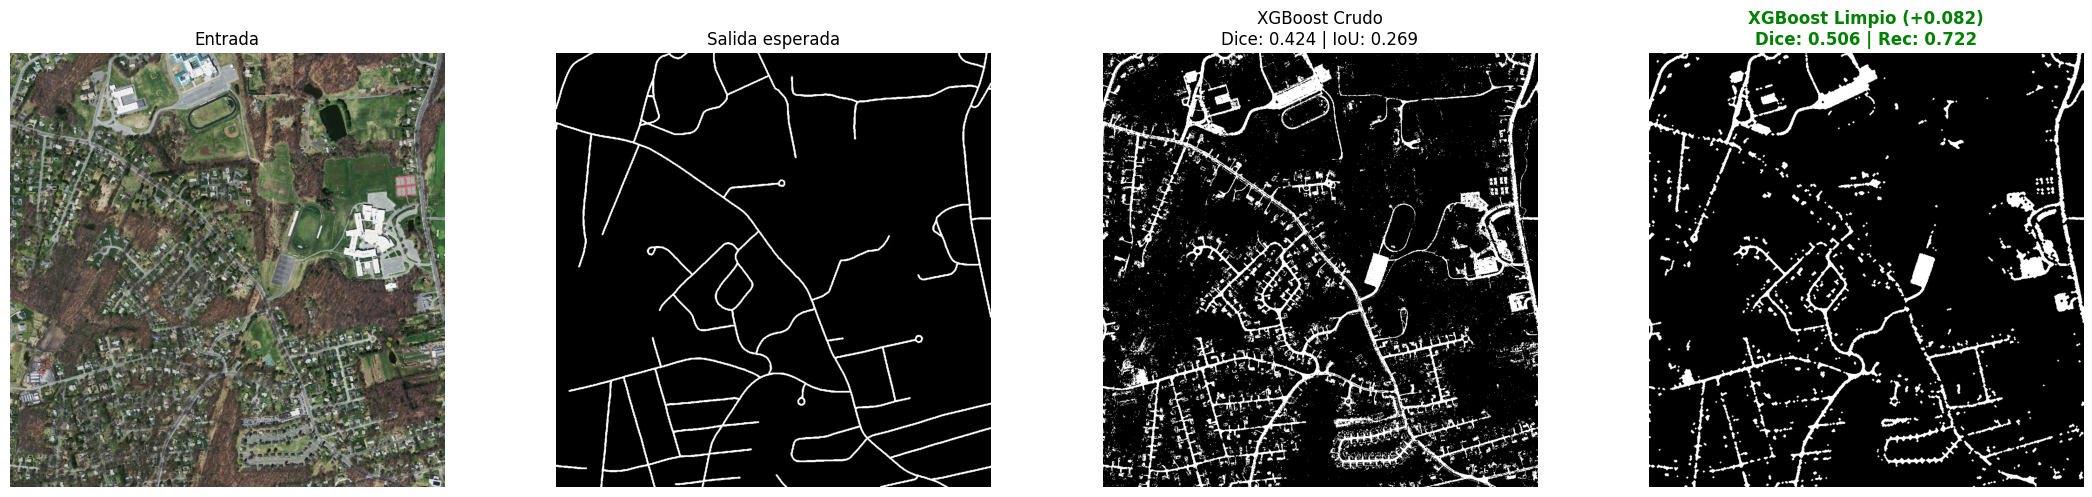

Procesada imagen 1/1


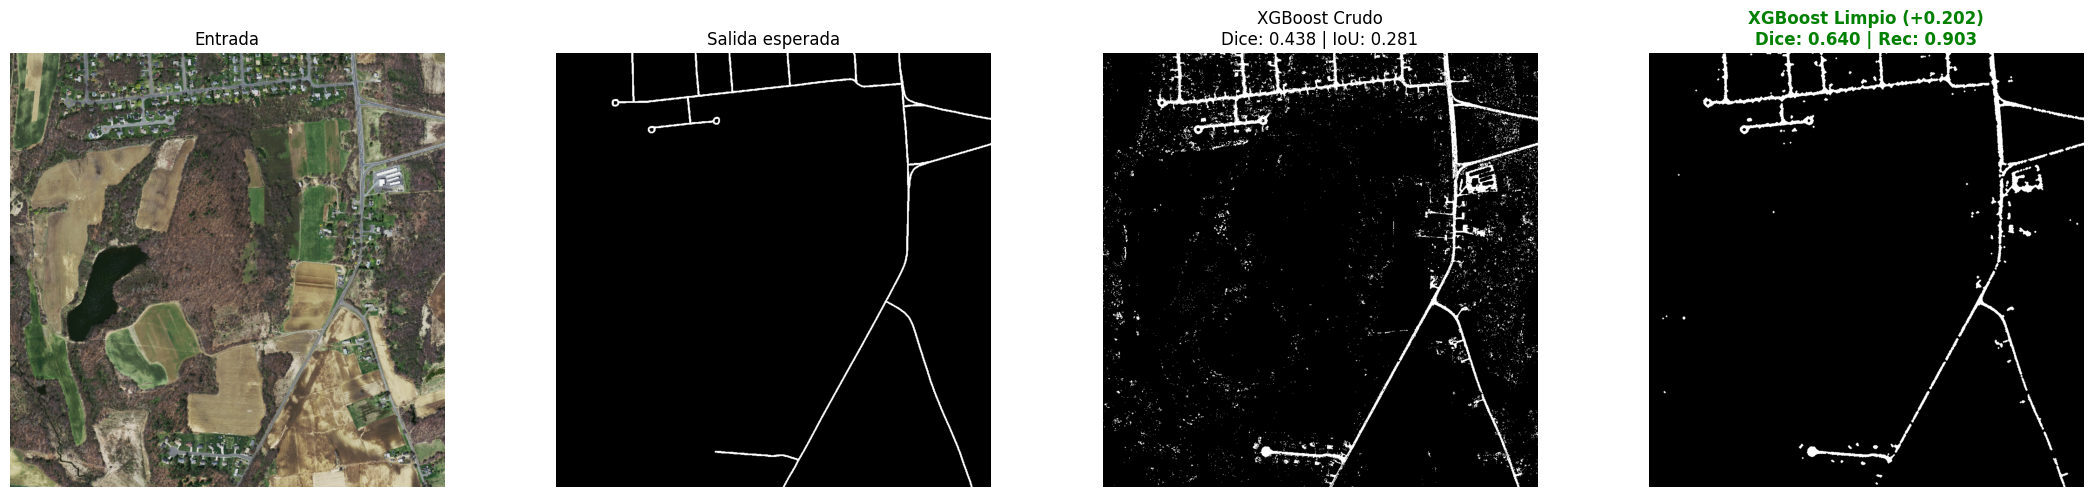


XGBoost
Métrica         | CRUDO      | LIMPIO     | Mejora
------------------------------------------------------------
DICE (F1)       | 0.4312     | 0.5731     | +0.1419
JACCARD (IoU)   | 0.2749     | 0.4047     | +0.1298
ACCURACY        | 0.9220     | 0.9567     | +0.0348
RECALL          | 0.9016     | 0.8125     | -0.0891


############################################################
PROCESANDO MODELO: Decision Tree
############################################################
Procesada imagen 1/1


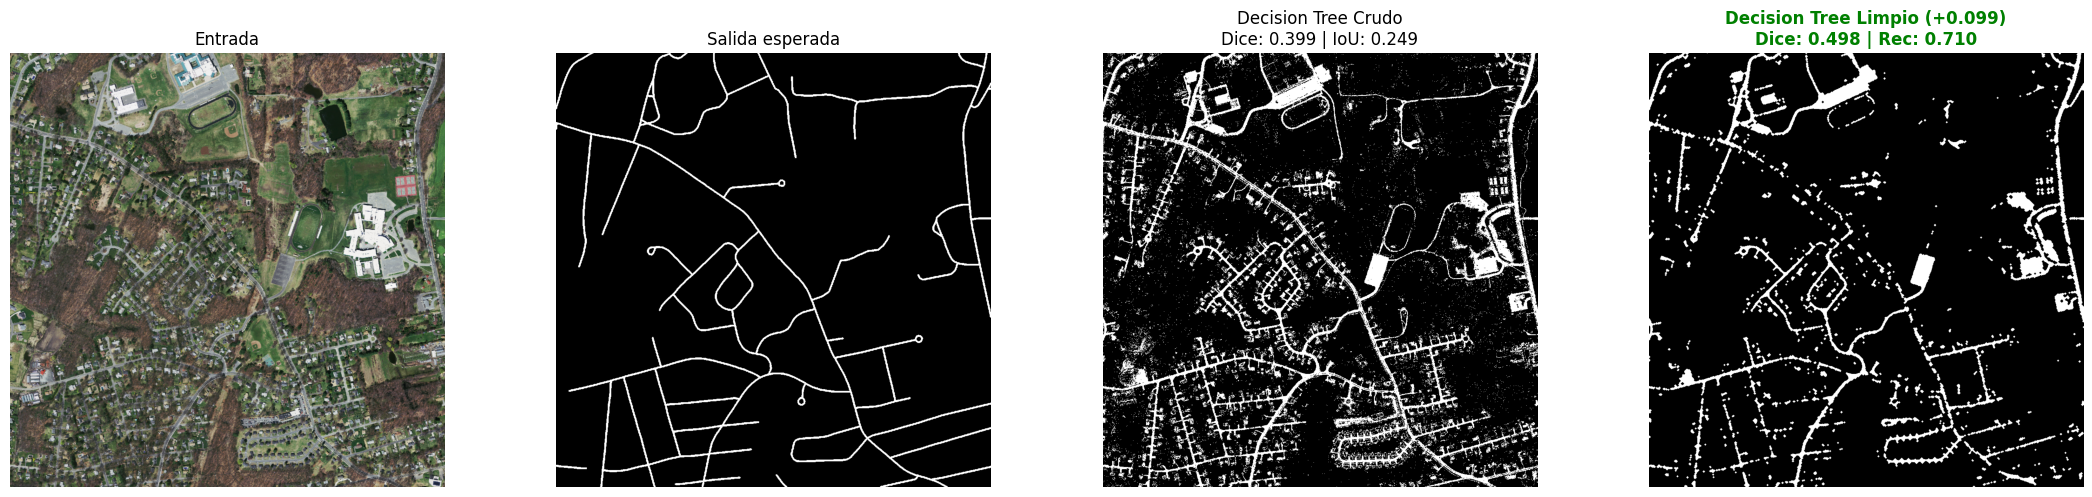

Procesada imagen 1/1


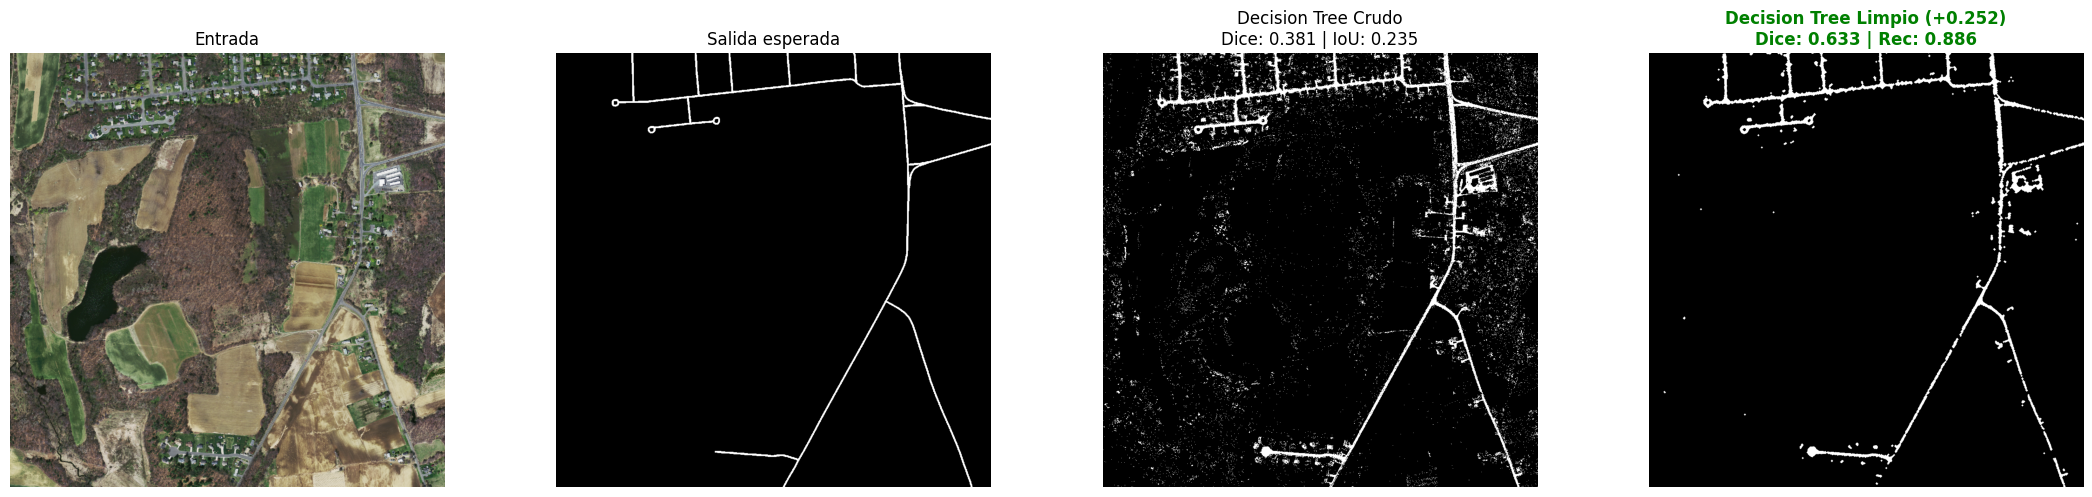


Decision Tree
Métrica         | CRUDO      | LIMPIO     | Mejora
------------------------------------------------------------
DICE (F1)       | 0.3901     | 0.5656     | +0.1755
JACCARD (IoU)   | 0.2423     | 0.3974     | +0.1551
ACCURACY        | 0.9107     | 0.9561     | +0.0454
RECALL          | 0.8966     | 0.7981     | -0.0985


############################################################
PROCESANDO MODELO: SVM (Linear)
############################################################
Procesada imagen 1/1


In [ ]:
# Definir modelos
models_config = {
    "XGBoost": xgb.XGBClassifier(
        n_estimators=200, learning_rate=0.1, max_depth=8,
        subsample=0.8, colsample_bytree=0.8, objective='binary:logistic',
        n_jobs=-1, tree_method='hist', random_state=SEED
    ),
    
    "Decision Tree": DecisionTreeClassifier(
        max_depth=15,      
        min_samples_leaf=4, 
        random_state=SEED
    ),
    
    "SVM (Linear)": Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(kernel='linear', C=1.0, cache_size=1000, random_state=SEED))
    ]),
    
    "KNN (k=5)": Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier(n_neighbors=5, weights='distance', n_jobs=-1))
    ])
}

# Función para postprocesado
def post_process_mask(mask, operations, radius=3, iterations=1):
    selem = disk(radius)
    mask = mask.astype(bool)
    for op in operations:
        if op == 'opening':
            for _ in range(iterations): mask = opening(mask, footprint=selem)
        elif op == 'closing':
            for _ in range(iterations): mask = closing(mask, footprint=selem)
        elif op == 'dilation':
            for _ in range(iterations): mask = dilation(mask, selem)
        elif op == 'erosion':
            for _ in range(iterations): mask = erosion(mask, selem)
    return mask.astype(np.uint8)

# Función de visualización
def visualizar_prediccion(indice_test_list, model_input, nombre_modelo):
    # entrada y salida test
    img_test = X_test_raw[indice_test_list]
    mask_real = y_test_raw[indice_test_list]
    
    # predicción
    features_img = extract_features([img_test])
    pred_vector = model_input.predict(features_img)
    
    y_true = mask_real.flatten()
    y_pred = pred_vector
    
    # Métricas Crudas
    metrics_raw = {
        'accuracy': accuracy_score(y_true, y_pred),
        'recall':   recall_score(y_true, y_pred),
        'jaccard':  jaccard_score(y_true, y_pred),
        'dice':     f1_score(y_true, y_pred)
    }
    
    # construir imagen
    mask_predicha = pred_vector.reshape(target_size)
    
    # POST-PROCESADO (opening, closing)
    lista_operaciones = ['opening', 'closing'] 
    mask_clean = post_process_mask(mask_predicha, operations=lista_operaciones, radius=2, iterations=1)
    
    # Métricas Limpias
    y_clean_flat = mask_clean.flatten()
    metrics_clean = {
        'accuracy': accuracy_score(y_true, y_clean_flat),
        'recall':   recall_score(y_true, y_clean_flat),
        'jaccard':  jaccard_score(y_true, y_clean_flat),
        'dice':     f1_score(y_true, y_clean_flat)
    }

    # Visualización
    fig, ax = plt.subplots(1, 4, figsize=(22, 5))
    ax[0].imshow(img_test); ax[0].set_title("Entrada")
    ax[1].imshow(mask_real, cmap='gray'); ax[1].set_title("Salida esperada")
    
    ax[2].imshow(mask_predicha, cmap='gray')
    ax[2].set_title(f"{nombre_modelo} Crudo\nDice: {metrics_raw['dice']:.3f} | IoU: {metrics_raw['jaccard']:.3f}")
    
    ax[3].imshow(mask_clean, cmap='gray')
    titulo = (f"{nombre_modelo} Limpio (+{metrics_clean['dice']-metrics_raw['dice']:.3f})\n"
              f"Dice: {metrics_clean['dice']:.3f} | Rec: {metrics_clean['recall']:.3f}")
    ax[3].set_title(titulo, color='green', fontweight='bold')
    
    for a in ax: a.axis('off')
    plt.tight_layout()
    plt.show()

    return metrics_raw, metrics_clean

# Entrenar y evaluar

for name, model in models_config.items():
    print("\n" + "#"*60)
    print(f"PROCESANDO MODELO: {name}")
    print("#"*60)
    
    # Entrenar
    if name == "XGBoost":
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=0)
    
    elif name in ["KNN (k=5)", "SVM (Linear)"]:
        # Para KNN hacemos un resample extra (evitar exceso RAM)
        X_knn, y_knn = resample(X_train, y_train, n_samples=50000, random_state=SEED)
        model.fit(X_knn, y_knn)
    
    else:
        model.fit(X_train, y_train)
    
    # Evaluar
    
    # Listas para guardar las medias del modelo
    lists_raw = {'acc': [], 'dice': [], 'rec': [], 'iou': []}
    lists_clean = {'acc': [], 'dice': [], 'rec': [], 'iou': []}

    # Visualizar
    for i in range(len(X_test_raw)):
        m_raw, m_clean = visualizar_prediccion(i, model, name)
        
        # Guardar resultados
        lists_raw['acc'].append(m_raw['accuracy']);   lists_clean['acc'].append(m_clean['accuracy'])
        lists_raw['dice'].append(m_raw['dice']);      lists_clean['dice'].append(m_clean['dice'])
        lists_raw['rec'].append(m_raw['recall']);     lists_clean['rec'].append(m_clean['recall'])
        lists_raw['iou'].append(m_raw['jaccard']);    lists_clean['iou'].append(m_clean['jaccard'])
    
    # Resumen final
    print("="*60)
    print(f"{'Métrica':<15} | {'CRUDO':<10} | {'LIMPIO':<10} | {'Mejora'}")
    print("-" * 60)
    
    def print_row(metric_name, key):
        mean_raw = np.mean(lists_raw[key])
        mean_clean = np.mean(lists_clean[key])
        diff = mean_clean - mean_raw
        print(f"{metric_name:<15} | {mean_raw:.4f}     | {mean_clean:.4f}     | {diff:+.4f}")

    print_row("DICE (F1)", 'dice')
    print_row("JACCARD (IoU)", 'iou')
    print_row("ACCURACY", 'acc')
    print_row("RECALL", 'rec')
    print("="*60 + "\n")

## Comparativa de características usando XGBoost
### Como hemos visto que XGBoost es el clasificador que mejor se adapta a nuestro problema, ahora realizamos una comparativa de las distintas características extraídas para ver cuáles son las más relevantes. Para ello, entrenamos y evaluamos el modelo usando diferentes combinaciones de las mismas. Las combinaciones que probamos son: (RGB, RGB + textura, Cromáticos, RGB + bordes, Todos)
- Definimos el modelo XGBoost con los hiperparámetros que mejor rendimiento nos han dado.
- Creamos una matriz para almacenar las características a evaluar y sacamos las combinaciones a probar.
- Incluimos otra vez la función de post-procesado con las operaciones matemáticas morfológicas.
- La función de visualización y cálculo de resultados se adapta para comparar las distintas combinaciones de características, manteniendo las mismas métricas que antes.
- Por último, llamamos a esta función para cada combinación de características y mostramos los resultados obtenidos, observando así cuáles son las más relevantes para nuestro problema.

In [ ]:
# Definimos el modelos
base_model_config = xgb.XGBClassifier(
    n_estimators=150, learning_rate=0.1, max_depth=8,
    subsample=0.8, colsample_bytree=0.8, objective='binary:logistic',
    n_jobs=-1, tree_method='hist', random_state=SEED
)

#Selección de características
feature_map = {
    'rgb':      [0, 1, 2],
    'hsv':      [3, 4],
    'lab':      [5],
    'bordes':   [6, 7],
    'textura':  [8],
    'contexto': [9]
}

# Combinaciones a probar 
experiments_config = {
    "1. Solo RGB":             ['rgb'],
    "2. RGB + Textura":        ['rgb', 'textura'],
    "3. RBG + HSV + Lab":      ['rgb', 'hsv', 'lab'],
    "4. RGB + Bordes":         ['rgb', 'bordes'],
    "5. Full (Todas)":         ['rgb', 'hsv', 'lab', 'bordes', 'textura', 'contexto']
}

# Seleccionar características 
def select_columns(X_full, feature_keys):
    indices = []
    for key in feature_keys:
        indices.extend(feature_map[key])
    return X_full[:, indices]

# Funciones de postprocesado
def post_process_mask(mask, operations, radius=3, iterations=1):
    selem = disk(radius)
    mask = mask.astype(bool)
    for op in operations:
        if op == 'opening':
            for _ in range(iterations): mask = opening(mask, footprint=selem)
        elif op == 'closing':
            for _ in range(iterations): mask = closing(mask, footprint=selem)
        elif op == 'dilation':
            for _ in range(iterations): mask = dilation(mask, selem)
        elif op == 'erosion':
            for _ in range(iterations): mask = erosion(mask, selem)
    return mask.astype(np.uint8)

# Función de visualización
def visualizar_experimento(idx, model, feat_keys, exp_name):
    # Entrada y Salida
    img_test = X_test_raw[idx]
    mask_real = y_test_raw[idx]
    y_true = mask_real.flatten()
    
    # Extraer características
    feats_full = extract_features([img_test])
    feats_selected = select_columns(feats_full, feat_keys)
    
    # Predicción 
    pred_vector = model.predict(feats_selected)
    
    # Métricas Crudas
    m_raw = {
        'dice': f1_score(y_true, pred_vector),
        'iou':  jaccard_score(y_true, pred_vector),
        'acc':  accuracy_score(y_true, pred_vector),
        'rec':  recall_score(y_true, pred_vector)
    }
    
    # Postprocesado
    mask_pred = pred_vector.reshape(target_size)
    mask_clean = post_process_mask(mask_pred, ['opening', 'closing'], radius=2)
    y_clean = mask_clean.flatten()
    
    # Métricas Limpias
    m_clean = {
        'dice': f1_score(y_true, y_clean),
        'iou':  jaccard_score(y_true, y_clean),
        'acc':  accuracy_score(y_true, y_clean),
        'rec':  recall_score(y_true, y_clean)
    }
    
    # Visualizar
    fig, ax = plt.subplots(1, 4, figsize=(22, 5))
    
    # Entrada
    ax[0].imshow(img_test)
    ax[0].set_title("Entrada")
    ax[0].axis('off')
    
    # Salida esperada
    ax[1].imshow(mask_real, cmap='gray')
    ax[1].set_title("Salida esperada")
    ax[1].axis('off')
    
    # Crudo
    ax[2].imshow(mask_pred, cmap='gray')
    ax[2].set_title(f"Crudo\nDice: {m_raw['dice']:.3f} | IoU: {m_raw['iou']:.3f}")
    ax[2].axis('off')
    
    # Limpio
    ax[3].imshow(mask_clean, cmap='gray')
    mejora = m_clean['dice'] - m_raw['dice']
    titulo = (f"Limpio (+{mejora:.3f})\n"
              f"Dice: {m_clean['dice']:.3f} | Rec: {m_clean['rec']:.3f}")
    ax[3].set_title(titulo, color='green' if mejora > 0 else 'black', fontweight='bold')
    ax[3].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return m_raw, m_clean

# Entrenar y Evaluar
print(f"\n{'#'*60}")
print("ANÁLISIS DE CARACTERÍSTICAS")
print(f"{'#'*60}")

for exp_name, features_to_use in experiments_config.items():
    print(f"\nEXPERIMENTO: {exp_name} | Features: {features_to_use}")
    
    # Seleccionar características
    X_train_sub = select_columns(X_train, features_to_use)
    X_val_sub   = select_columns(X_val, features_to_use) 
    
    # Entrenar
    current_model = xgb.XGBClassifier(**base_model_config.get_params())
    current_model.fit(X_train_sub, y_train, eval_set=[(X_val_sub, y_val)], verbose=0)
    
    # Evaluar
    # Listas para guardar medias
    lists_raw = {'acc': [], 'dice': [], 'rec': [], 'iou': []}
    lists_clean = {'acc': [], 'dice': [], 'rec': [], 'iou': []}

    # Visualización
    for i in range(len(X_test_raw)):
        r, c = visualizar_experimento(i, current_model, features_to_use, exp_name)
        
        # Guardar métricas
        for k in lists_raw.keys():
            lists_raw[k].append(r[k])
            lists_clean[k].append(c[k])
    
    # Resumen final
    print(f"{'Métrica':<15} | {'CRUDO':<10} | {'LIMPIO':<10} | {'MEJORA'}")
    print("-" * 60)
    
    metricas_orden = ['dice', 'iou', 'acc', 'rec']
    nombres_orden = ['DICE (F1)', 'JACCARD (IoU)', 'ACCURACY', 'RECALL']
    
    for nombre, key in zip(nombres_orden, metricas_orden):
        m_raw = np.mean(lists_raw[key])
        m_cln = np.mean(lists_clean[key])
        diff = m_cln - m_raw
        print(f"{nombre:<15} | {m_raw:.4f}     | {m_cln:.4f}     | {diff:+.4f}")
        
    print("="*60 + "\n")